github link: https://github.com/augustthedoodle/ecen610

LAB 4
Sampler Error Modeling and Correction
1. First order model of a ZOH sampling circuit
Construct a model for a sampling circuit shown in Fig. 1.

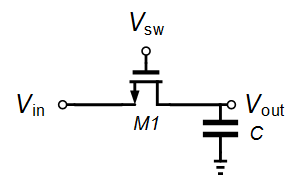

When the NMOS switch M1 is ON (Vsw = 1), the sampling circuit behaves as a series RC circuit and the input Vin is sampled on the capacitor. When the switch turns OFF (Vsw = 0), the voltage on the capacitor is held constant until the beginning of the next sampling phase. If the ON resistance of the switch is R, then the time constant of the sampler, τ, is R*C.
a. For an input sinusoidal signal of frequency 1 GHz, a sampling frequency of 10 GHz and time constant of 10 ps, plot the output of the sampling circuit.

[ANS] 
Input sinusoidal signal is x(t)=sin(2πFint), Fin=1GHz.
Sampling frequency Fs=10GHz, or Ts=100ps. Sampling occurs at nTs.
The sampling circuit has a first-order response modeled as an RC circuit with a time constant of 10 ps. The response can be expressed as:
y(t)=x(t)⋅(1−exp(-t/τ))


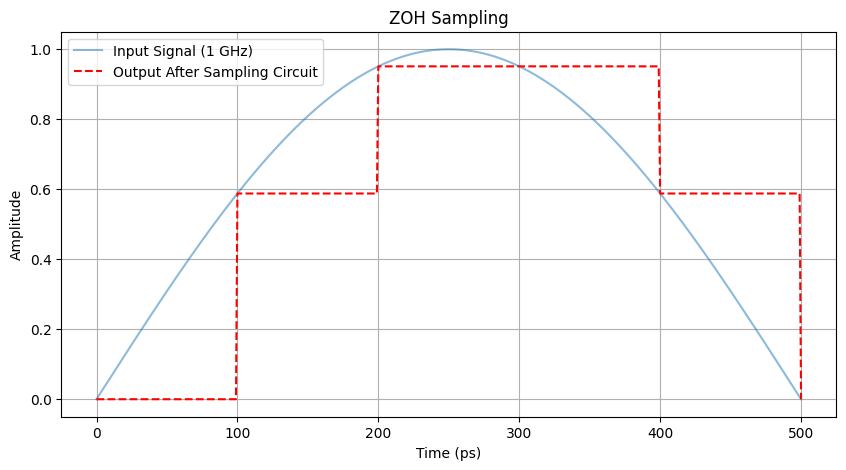

In [6]:
import numpy as np
import matplotlib.pyplot as plt

A = 1  # Amplitude of sine wave
f_in = 1e9  # Input frequency (1 GHz)
f_s = 10e9  # Sampling frequency (10 GHz)
tau = 10e-12  # Time constant (10 ps)
T_s = 1 / f_s  # Sampling period
alpha = 1 - np.exp(-T_s / tau)  # RC update factor

t_end = 5 * T_s  # Total simulation time
dt = 1e-12  # Small time step (1 ps)
t_values = np.arange(0, t_end, dt)  # Time vector

y_out = np.zeros_like(t_values)
x_sample = 0  # Last sampled value
y_prev = 0  # Previous output

# Loop through time
for i, t in enumerate(t_values):
    # Every T_s, take a new sample
    if i % int(T_s / dt) == 0:
        x_sample = A * np.sin(2 * np.pi * f_in * t)

    # Apply RC response recursively
    y_out[i] = y_prev + alpha * (x_sample - y_prev)
    y_prev = y_out[i]  # Store for next iteration

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(t_values * 1e12, A * np.sin(2 * np.pi * f_in * t_values), label="Input Signal (1 GHz)", alpha=0.5)
plt.plot(t_values * 1e12, y_out, label="Output After Sampling Circuit", linestyle="--", color="r")
plt.xlabel("Time (ps)")
plt.ylabel("Amplitude")
plt.title("ZOH Sampling")
plt.legend()
plt.grid()
plt.show()


2. Sampling Error

Sampling error is the difference between an ideally sampled signal (delta train) and a signal sampled with a finite time constant sampling circuit.

a. Assume a NRZ (Non Return to Zero) input of amplitude 0.5 V and data rate of 10 Gb/s. Sample the input signal once in the middle of every bit period. Assuming a 50% duty cycle for Vsw in Fig. 1, what should the time constant be for the maximum sampling error to be less than 1 LSB for a 7-bit ADC with a full scale range of 1 V. Justify with an equation the obtained time constant value.

[ANS]
LSB of full scale Vfs=1V, 7-bit ADC is,
1/(2^7) = 1/128 = 7.8125mV

Data Rate: 10 Gb/s, bit period Tb=100 ps

The sampling circuit behaves as an RC low-pass filter, causing an exponential response.
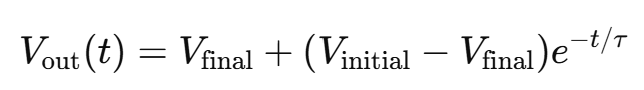

For worst-case analysis, assume a full 0.5V transition occurs at the bit boundary, and the voltage is sampled at Tb/2=50 ps:

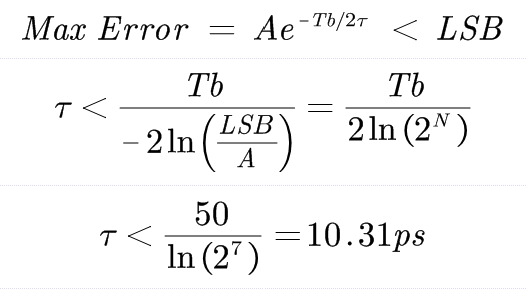



b. Assume a multi-tone signal input with frequencies of 0.2 GHz, 0.58 GHz, 1 GHz, 1.7 GHz and 2.4 GHz and a sampling frequency of 10 GHz. What should the time constant be for the sampling error to be less than 1 LSB for a 7-bit ADC? Is it different from the time constant in 2.a? Why?

[ANS]
based on max sampling error equation from a), the requirement for the time constant depends on the sampling period only. Since the same sampling period is used for multi-tone signal, the same time constant is required as a).

3. Sampling Error Estimation
Construct an ADC model by adding an N-bit quantizer (N=7) at the output of the sampling circuit.
a. Let the input to the ADC be the multitone signal generated in 2.b. At the ADC output, find the error, E, between the quantized signal sampled with a sampling circuit having the time constant derived 2.a and an ideally sampled signal. What is the variance of E? What is ratio of the variance of E to the variance of the uniform quantization noise?

[ANS]
The input is a sum of sinusoids: 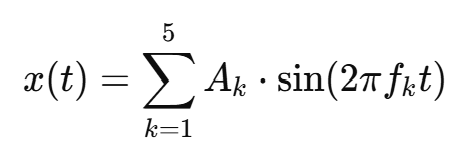
Assume all amplitudes Ak =0.2 V (so total peak ≈ 1V full scale).

Use 10G as sampling frequency, Ts=100ps
- for ideal sampled signal, x[n]=x(nTs)
- for RC sampling circuit, impulse response is 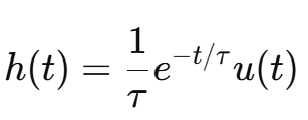

x[n] can be obtained by convolving input signal with the impulse reponse, or solve the differential equation,

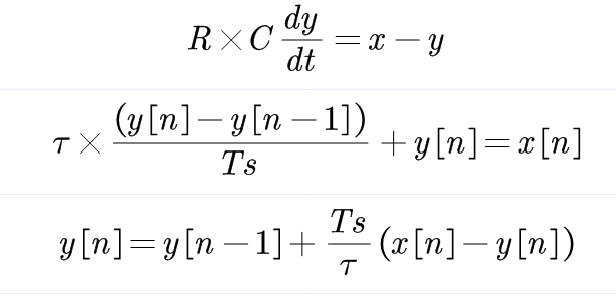

Actually use the first order approximation, dy/dt=(y[n]-y[n-1])/Ts caused overflow. Instead exponential decay is used.

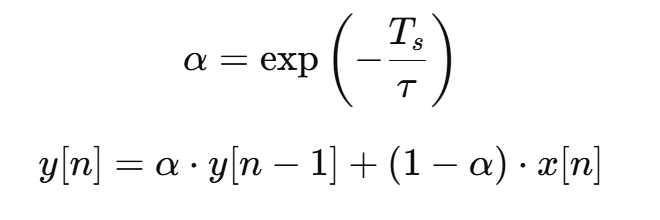

Result shows variance of sampling error is around 0.07 of the quantization error.

Variance of error: 3.660e-07
Variance of quantization noise: 5.086e-06
Ratio (Error / Quantization): 0.07

Variance of error: 3.660e-07
Variance of quantization noise: 5.086e-06
Ratio (Error / Quantization): 0.07


<module 'matplotlib.pyplot' from '/home/sxie/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

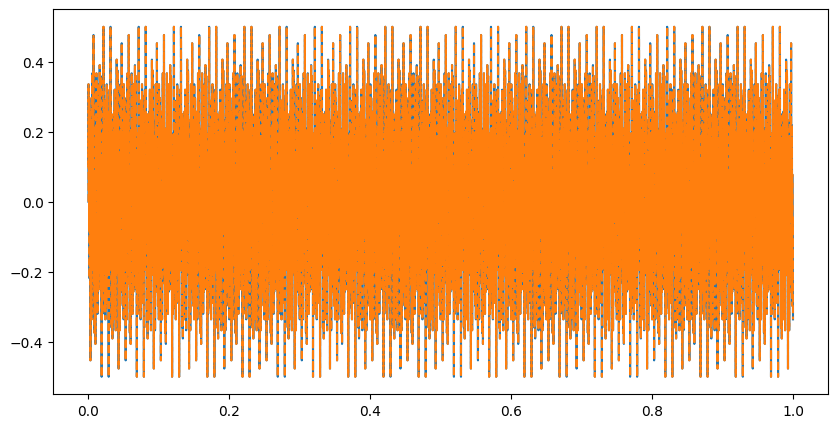

In [11]:
import numpy as np
import matplotlib.pyplot as plt

Fs = 10e9             
Ts = 1 / Fs           
t_end = 1e-6 
t = np.arange(0, t_end, Ts)

# Multi-tone input signal
frequencies = [0.2e9, 0.58e9, 1e9, 1.7e9, 2.4e9]
x = np.sum([np.sin(2 * np.pi * f * t) for f in frequencies], axis=0)

# Normalize amplitude to full-scale of 7-bit ADC (±0.5 V for 1 Vpp)
x = 0.5 * x / np.max(np.abs(x))

# RC time constant from 2a.
tau = 10.3e-12
alpha = np.exp(-Ts / tau)

# RC sampling model: simple first-order response
y = np.zeros_like(x)

# Ts >> tau, causes overflow
#for i in range(1, len(x)):
#    y[i] = y[i - 1] + (Ts / tau) * (x[i] - y[i - 1])

for i in range(1, len(x)):
    y[i] = alpha * y[i - 1] + (1 - alpha) * x[i]

# Quantizer (7-bit, 1 V full scale → ±0.5V range)
N_bits = 7
Vref = 1.0      # Full scale voltage
LSB = Vref / (2**N_bits)
y_quantized = np.round((y + 0.5) / LSB) * LSB - 0.5

# Ideal sampled and quantized signal
x_quantized = np.round((x + 0.5) / LSB) * LSB - 0.5

# Error signal
E = y_quantized - x_quantized
var_E = np.var(E)
var_q = LSB**2 / 12
ratio = var_E / var_q

# Display results
print(f"Variance of error: {var_E:.3e}")
print(f"Variance of quantization noise: {var_q:.3e}")
print(f"Ratio (Error / Quantization): {ratio:.2f}")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(t * 1e6, x_quantized, label='Ideal Quantized')
plt.plot(t * 1e6, y_quantized, label='RC Sampled & Quantized', linestyle='--')
plt


b. In this model, the ADC output at time instant i has both a sampling error and a quantization error. Using least squares estimation, construct an M-tap FIR filter that estimates the sampling error at the ADC output using M-1 previous ADC output values. Add the estimated error to the ADC output and compute the error signal, E, defined in 3.a. Plot the ratio of the variance of E to the variance of uniform quantization noise as M is varied from 2 to 10. What do you infer from this plot?

[ANS]
We have an imperfect ADC output due to:
-Finite sampling time constant (τ)
-Quantization (7-bit in this case)

We aim to estimate the sampling error from past ADC outputs and then use it to correct future samples. We assume the error is correlated with recent ADC outputs, so we can model it with a linear FIR filter.

Suppose we want to estimate the error E[n] at sample n using a linear combination of current and previous M-1 ADC outputs,
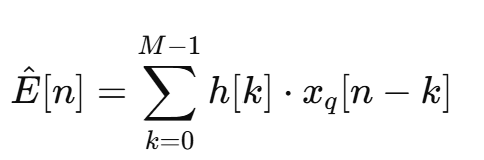
 
Our goal is to find the optimal filter coefficients h[k], k=0 .. M-1 that minimize the square error by solving,

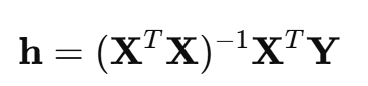

Steps in code:
1.	Form matrix of past ADC outputs
2.	Use actual error as target
3.	Solve least squares for filter taps
4.	Estimate error from past ADC
5.	Add estimated error to ADC output
6.	Evaluate improvement via variance

Result shows variance of corrected signal error increases along with M, which means M could overfit after 3?

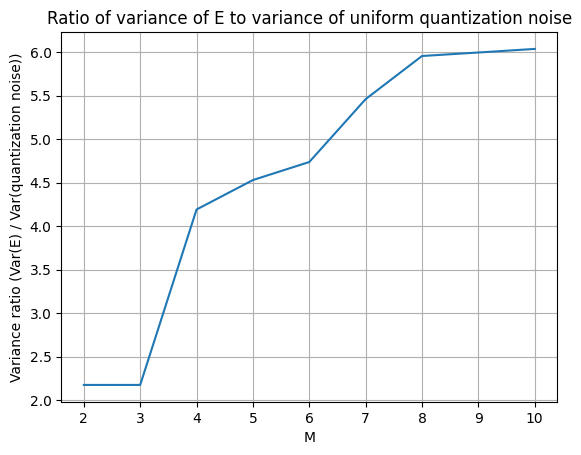

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# least square error
def estimate_error(adc_output, M):
    N = len(adc_output)
    error_estimates = np.zeros(N)
    for i in range(M - 1, N):
        X = np.zeros((1, M - 1))
        X[0, :] = adc_output[i - M + 1:i]
        y = np.array([adc_output[i]])
        try:
            w = np.linalg.pinv(X.T @ X) @ X.T @ y
        except np.linalg.LinAlgError:
            w = np.zeros((M - 1, 1))
        error_estimates[i] = np.dot(adc_output[i - M + 1:i], w.flatten())
    return error_estimates


# calculate E
def compute_error_signal(adc_output, error_estimates):
    return adc_output - error_estimates

def compute_variance_ratio(E, Q):
    quantization_noise_variance = Q**2 / 12
    E_variance = np.var(E)
    return E_variance / quantization_noise_variance

Fs = 10e9             
Ts = 1 / Fs

Nbits = 7                       # ADC resolution
VFS = 1.0                       # Full scale
delta = VFS / (2**Nbits)       # Quantization step

t_end = 1e-6 
t = np.arange(0, t_end, Ts)

# Multi-tone input signal
frequencies = [0.2e9, 0.58e9, 1e9, 1.7e9, 2.4e9]
x = np.sum([np.sin(2 * np.pi * f * t) for f in frequencies], axis=0)

# Normalize amplitude to full-scale of 7-bit ADC (±0.5 V for 1 Vpp)
x = 0.5 * x / np.max(np.abs(x))

# RC time constant from 2a.
tau = 10.3e-12
alpha = np.exp(-Ts / tau)

# RC sampling model: simple first-order response
y = np.zeros_like(x)

for i in range(1, len(x)):
    y[i] = alpha * y[i - 1] + (1 - alpha) * x[i]

M_values = np.arange(2, 11)
variance_ratios = []

for M in M_values:
    error_estimates = estimate_error(y, M)
    E = compute_error_signal(y, error_estimates)
    ratio = compute_variance_ratio(E, delta)
    variance_ratios.append(ratio)

plt.plot(M_values, variance_ratios)
plt.xlabel('M')
plt.ylabel('Variance ratio (Var(E) / Var(quantization noise))')
plt.title('Ratio of variance of E to variance of uniform quantization noise')
plt.grid(True)
plt.show()
    

4. Calibration of Errors in a Two-Channel TI-ADC
a. Construct a simulation of a 2-way TI-ADC that includes time, offset and bandwidth mismatches between the channels. Provide SNDR plots following the setup in 2(a) for the design of the input signal.

[ANS]
To simulate a 2-way Time-Interleaved ADC (TI-ADC) with mismatches and analyze Signal-to-Noise-and-Distortion Ratio (SNDR),
- Time skew (Δt) between channels
- Offset mismatch
- Bandwidth mismatch (different RC constants)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

# Parameters
bitrate = 10e9                  # 10 Gbps NRZ
bit_period = 1 / bitrate        # 100 ps
Fs = 2 * bitrate                # 2x oversampling, interleaved
Ts = 1 / Fs                     # Sampling interval (50 ps)
Vfs = 1.0                       # Full scale voltage
Nbits = 7
q_step = Vfs / (2**Nbits)
tau_nominal = 10.3e-12          # Nominal RC time constant

# Mismatch parameters
offset_mismatch = 5e-3          # 5 mV offset mismatch
timing_skew = 3e-12             # 3 ps skew between channels
tau_mismatch = 12e-12           # Slightly different bandwidth

# Generate NRZ data
Nbits_data = 2048
data = np.random.choice([0, 1], Nbits_data)
nrz_signal = data * Vfs         # 0 or 1 V

# Time vector for signal generation
T_total = Nbits_data * bit_period
t_highres = np.arange(0, T_total, Ts / 10)
signal_highres = np.repeat(nrz_signal, int(bit_period / (Ts / 10)))

# Interleaved sampling times
t0 = np.arange(0, T_total, 2 * Ts) + Ts / 2    # Channel 0
t1 = np.arange(Ts, T_total, 2 * Ts) + Ts / 2 + timing_skew   # Channel 1 (skewed)

# Interpolate signal for each channel (ideal samples)
signal_interp = np.interp

# RC sampling model
def rc_sample(signal_in, tau, Ts):
    y = np.zeros_like(signal_in)
    alpha = np.exp(-Ts / tau)
    for i in range(1, len(signal_in)):
        y[i] = alpha * y[i - 1] + (1 - alpha) * signal_in[i]
    return y

# Sample signal for each channel
ideal_0 = signal_interp(t0, t_highres, signal_highres)
ideal_1 = signal_interp(t1, t_highres, signal_highres)

# Apply RC effect
ch0_out = rc_sample(ideal_0, tau_nominal, 2 * Ts)
ch1_out = rc_sample(ideal_1, tau_mismatch, 2 * Ts)

# Add offset to ch1
ch1_out += offset_mismatch

# Quantize
ch0_q = np.round(ch0_out / q_step) * q_step
ch1_q = np.round(ch1_out / q_step) * q_step

# Reconstruct interleaved signal
adc_out = np.empty(len(ch0_q) + len(ch1_q))
adc_out[0::2] = ch0_q
adc_out[1::2] = ch1_q

# Reference ideal signal (sampled at Fs)
t_fs = np.arange(0, T_total, Ts) + Ts / 2
ideal_adc = signal_interp(t_fs, t_highres, signal_highres)

# Error and SNDR calculation
error = adc_out - ideal_adc
signal_power = np.mean(ideal_adc**2)
noise_power = np.mean(error**2)
quant_error_var = (q_step**2) / 12
SNDR = 10 * np.log10(signal_power / noise_power)

# Display results
print(f"Variance of error: {noise_power:.3e}")
print(f"Variance of quantization noise: {quant_error_var:.3e}")
print(f"SNDR: {SNDR:.2f}")

# # Plot time-domain result
# plt.figure(figsize=(10, 4))
# plt.plot(t_fs[:300]*1e12, ideal_adc[:300], label="Ideal")
# plt.plot(t_fs[:300]*1e12, adc_out[:300], 'o--', label="TI-ADC Output")
# plt.xlabel("Time (ps)")
# plt.ylabel("Voltage (V)")
# plt.title(f"2-Way TI-ADC Output with Mismatches\nSNDR ≈ {SNDR:.2f} dB")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Frequency-domain plot (FFT)
# adc_fft = np.abs(fft(adc_out * np.hanning(len(adc_out))))[:len(adc_out)//2]
# adc_fft_db = 20 * np.log10(adc_fft / np.max(adc_fft))

# plt.figure(figsize=(10, 4))
# plt.plot(np.linspace(0, Fs/2, len(adc_fft_db)) / 1e9, adc_fft_db)
# plt.title("Spectrum of TI-ADC Output")
# plt.xlabel("Frequency (GHz)")
# plt.ylabel("Magnitude (dB)")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


Variance of error: 3.052e-05
Variance of quantization noise: 5.086e-06
SNDR: 42.22


b. Construct a calibration technique capable of compensating the time, offset and bandwidth mismatches between the channels following the techniques described in the references.

[ANS] summary of calibration out of the references,
- Offset Mismatch Compensation
Subtract the estimated DC offset of each channel before interleaving.

- Timing Mismatch Compensation
Use digital resampling or interpolation to align skewed samples to the correct positions.

- Bandwidth Mismatch Compensation
Apply an FIR filter to match the frequency response between channels.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

# Parameters
bitrate = 10e9
bit_period = 1 / bitrate
Fs = 2 * bitrate
Ts = 1 / Fs
Vfs = 1.0
Nbits = 7
q_step = Vfs / (2**Nbits)
tau_nominal = 10.3e-12

# Mismatch parameters
offset_mismatch = 5e-3
timing_skew = 3e-12
tau_mismatch = 12e-12

# Generate NRZ signal
Nbits_data = 2048
data = np.random.choice([0, 1], Nbits_data)
nrz_signal = data * Vfs
T_total = Nbits_data * bit_period
t_highres = np.arange(0, T_total, Ts / 10)
signal_highres = np.repeat(nrz_signal, int(bit_period / (Ts / 10)))

# Interleaved sampling times
t0 = np.arange(0, T_total, 2 * Ts) + Ts / 2
t1 = np.arange(Ts, T_total, 2 * Ts) + Ts / 2 + timing_skew

# Signal interpolator
interp = np.interp

# RC sampler
def rc_sample(signal_in, tau, Ts):
    y = np.zeros_like(signal_in)
    alpha = np.exp(-Ts / tau)
    for i in range(1, len(signal_in)):
        y[i] = alpha * y[i - 1] + (1 - alpha) * signal_in[i]
    return y

# Ideal samples
ideal_0 = interp(t0, t_highres, signal_highres)
ideal_1 = interp(t1, t_highres, signal_highres)

# Apply RC sampling
ch0_out = rc_sample(ideal_0, tau_nominal, 2 * Ts)
ch1_out = rc_sample(ideal_1, tau_mismatch, 2 * Ts) + offset_mismatch

# Quantize
ch0_q = np.round(ch0_out / q_step) * q_step
ch1_q = np.round(ch1_out / q_step) * q_step

# Assemble interleaved output
adc_out = np.empty(len(ch0_q) + len(ch1_q))
adc_out[0::2] = ch0_q
adc_out[1::2] = ch1_q

# Ideal full-speed sampled signal
t_fs = np.arange(0, T_total, Ts) + Ts / 2
ideal_adc = interp(t_fs, t_highres, signal_highres)

# Compute SNDR before calibration
error = adc_out - ideal_adc
signal_power = np.mean(ideal_adc**2)
noise_power = np.mean(error**2)
SNDR_before = 10 * np.log10(signal_power / noise_power)

print(f"Variance of error before calibration: {noise_power:.3e}")
print(f"Variance of quantization noise: {quant_error_var:.3e}")
print(f"SNDR before calibration: {SNDR_before:.2f}")

### === Calibration ===

# 1. Offset correction
ch1_q_corr = ch1_q - np.mean(ch1_q - ch0_q[:len(ch1_q)])

# 2. Timing skew correction (interpolate back to t1 - skew)
t1_corrected = t1 - timing_skew
ch1_q_corr = interp(t1_corrected, t1, ch1_q_corr)

# 3. Bandwidth mismatch equalization (1-tap de-emphasis)
bw_alpha = 0.9
ch1_q_eq = np.zeros_like(ch1_q_corr)
for i in range(1, len(ch1_q_corr)):
    ch1_q_eq[i] = ch1_q_corr[i] + bw_alpha * (ch1_q_corr[i] - ch1_q_corr[i-1])

# Reconstruct calibrated output
adc_cal = np.empty_like(adc_out)
adc_cal[0::2] = ch0_q
adc_cal[1::2] = ch1_q_corr

# SNDR after calibration
error_cal = adc_cal - ideal_adc
noise_power_cal = np.mean(error_cal**2)
SNDR_after = 10 * np.log10(signal_power / noise_power_cal)

# Display results
print(f"Variance of error after calibration: {noise_power_cal:.3e}")
print(f"SNDR after calibration: {SNDR_after:.2f}")


Variance of error before calibration: 1.507e-04
Variance of quantization noise: 5.086e-06
SNDR before calibration: 29.19
Variance of error after calibration: 1.774e-04
SNDR after calibration: 28.48
